In [1]:
%pylab inline
from analysis_toolbox import *
from qualityBaseline import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ../../BoundingBoxArchive/Code/

/Users/dorislee/Desktop/Research/seg/BoundingBoxArchive/Code


In [3]:
from greedy import *
from data import *
from experiment import *
import pandas as pd 

In [215]:
bb_info = pd.read_csv('../../crowd-seg/analysis/computed_my_COCO_BBvals.csv')
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [COCO]']!=0][bb_info['Jaccard [Self]']!=0].sort('object_id')
object_id_lst  = list(set(obj_sorted_tbl.object_id))

# for objid in object_id_lst:
objid=46
# Ji_tbl (bb_info) is the set of all workers that annotated object i 
bb_objects  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]

In [329]:
# for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"]):
#     xloc,yloc = process_raw_locs([x,y])
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [330]:
polygon_lst = []
for xyloc in xylocs:
    polygon_lst.append(Polygon(xyloc))

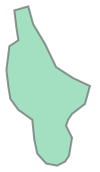

In [331]:
Polygon(xyloc)

In [15]:
from shapely.geometry import MultiPolygon

In [16]:
Ji_polygons = MultiPolygon(polygon_lst)
Ji_polygons_buffered = Ji_polygons.buffer(0.001)

In [17]:
import shapely

In [18]:
obj_x_locs = [process_raw_locs([x,y])[0] for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]
obj_y_locs = [process_raw_locs([x,y])[1] for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [324]:
from PIL import Image, ImageDraw
height =500
width=200
mega_mask = np.zeros((height,width))
img = Image.new('L', (width, height), 0)
for x_locs, y_locs in zip(obj_x_locs,obj_y_locs):
    ImageDraw.Draw(img).polygon(zip(x_locs,y_locs), outline=1, fill=1)
    mask = np.array(img)==1
    mega_mask+=mask

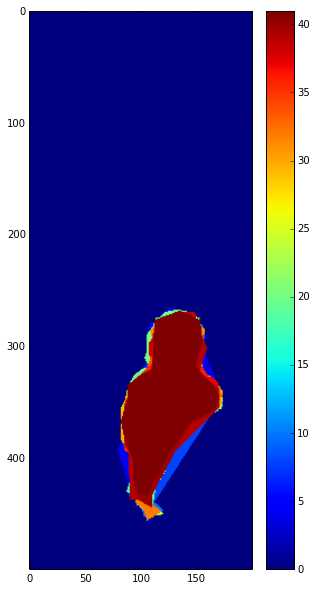

In [325]:
plt.figure(figsize=(5,10))
plt.imshow(mega_mask)
plt.colorbar()
# X,Y = np.meshgrid(width,height)
# plt.contour(X,Y,unique(mega_mask))

In [24]:
unique(mega_mask)

array([  0.,   2.,   4.,   5.,   6.,   7.,   8.,  10.,  13.,  14.,  16.,
        17.,  18.,  19.,  20.,  21.,  25.,  26.,  27.,  29.,  30.,  31.,
        32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.])

In [164]:
singly_masked_img = np.zeros_like(mega_mask)
for x,y in zip(*np.where(mega_mask==2)):
    singly_masked_img[x][y]=1

In [114]:
np.where(singly_masked_img!=0)

(array([441, 442, 443, 443, 443, 444, 444, 444, 445, 445, 445, 446, 446,
        446, 447, 454, 455, 455, 455, 456, 456, 456, 457, 457, 457, 458, 459]),
 array([ 95,  95,  95,  96,  97,  96,  97,  98,  97,  98,  99,  98,  99,
        100, 100, 109, 107, 108, 109, 106, 107, 108, 106, 107, 108, 107, 107]))

<matplotlib.colorbar.Colorbar instance at 0x1109999e0>

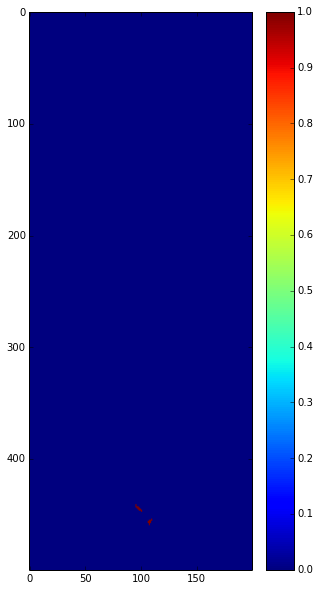

In [115]:
plt.figure(figsize=(5,10))
plt.imshow(singly_masked_img)
plt.colorbar()

Reference: http://stackoverflow.com/questions/18304722/python-find-contour-lines-from-matplotlib-pyplot-contour

In [320]:
from matplotlib import _cntr as cntr
x, y = np.mgrid[:singly_masked_img.shape[0], :singly_masked_img.shape[1]]
c = cntr.Cntr(x, y, singly_masked_img)
# trace a contour at z == 1
res = c.trace(0.9)

In [321]:
def plot_trace_contours(res):
    # result is a list of arrays of vertices and path codes
    # (see docs for matplotlib.path.Path)
    nseg = len(res) // 2
    segments, codes = res[:nseg], res[nseg:]

    fig, ax = plt.subplots(1, 1)
    img = ax.imshow(singly_masked_img.T, origin='lower',interpolation='none')
    plt.colorbar(img)
    ax.hold(True)
    for segment in segments:
        p = plt.Polygon(segment, fill=False, color='w')
        ax.add_artist(p)
        
    x= res[0][:,0]
    plt.xlim(min(x)-10,max(x)+20)
    y= res[0][:,1]
    plt.ylim(min(y)-10,max(y)+20)

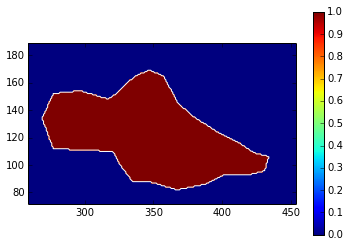

In [322]:
plot_trace_contours(res)

In [162]:
tiles = []
for segment in res:
    if segment.dtype!=np.uint8:
        tiles.append(segment)


---------------------------------------------------------------------------------------------------------------------

In [165]:
from matplotlib import _cntr as cntr

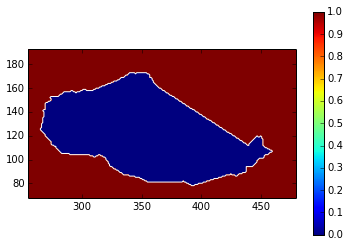

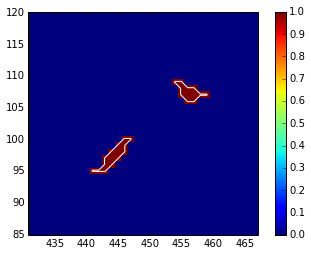

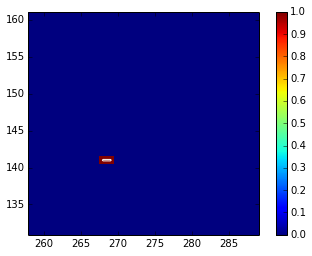

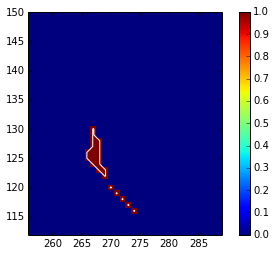

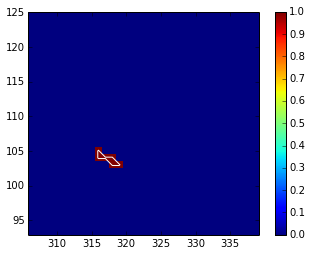

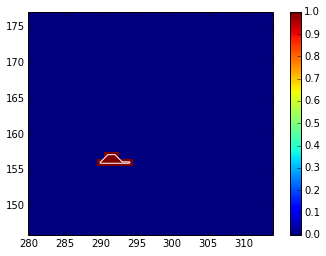

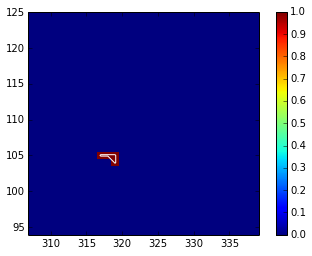

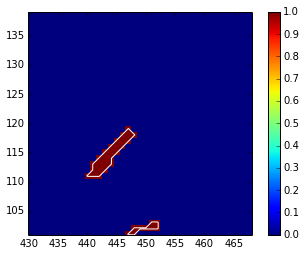

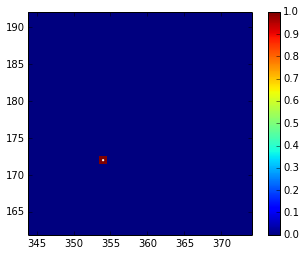

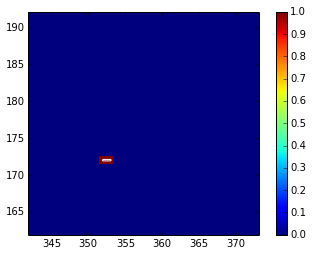

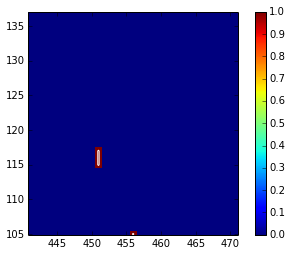

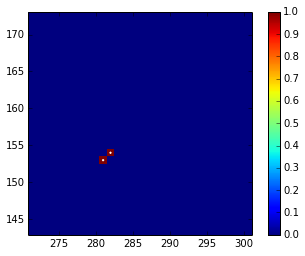

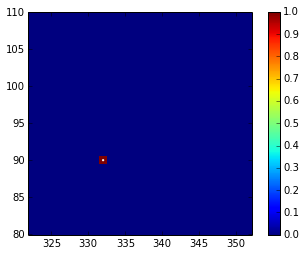

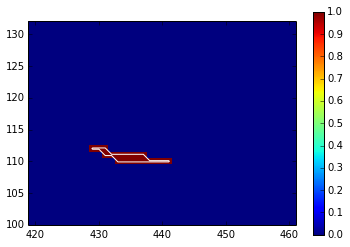

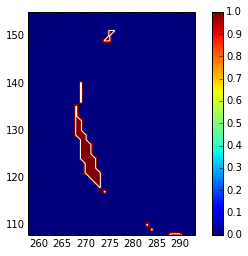

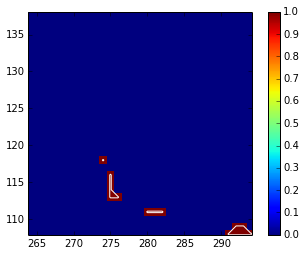

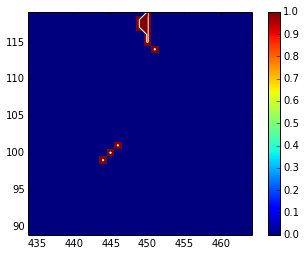

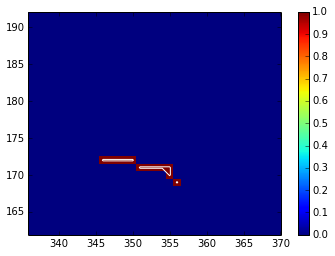

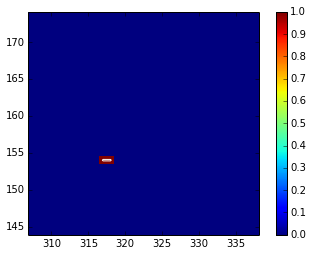

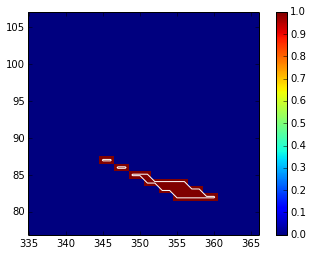

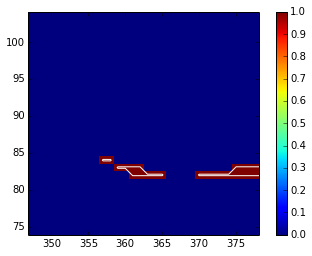

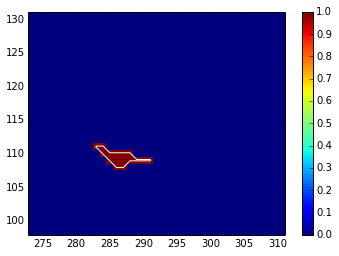

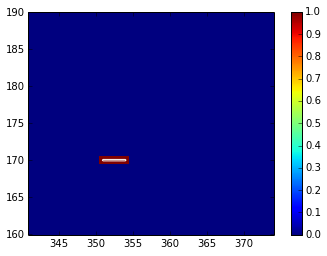

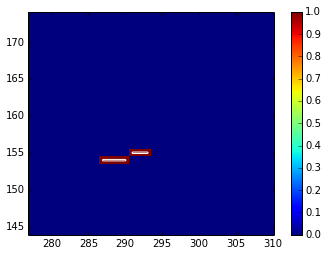

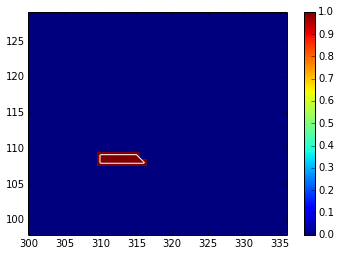

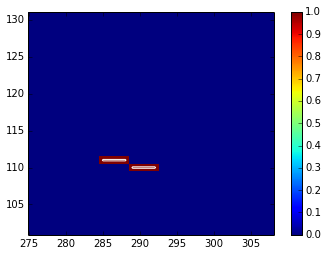

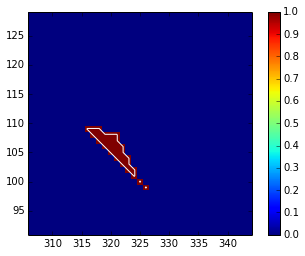

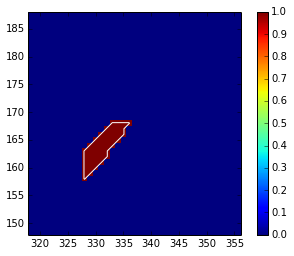

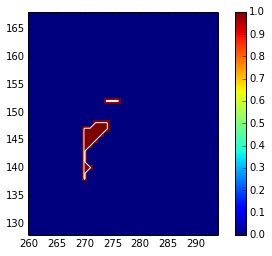

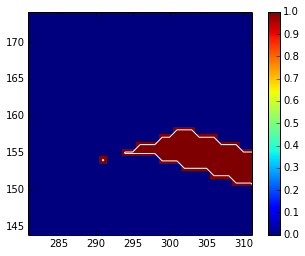

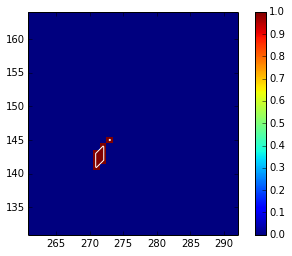

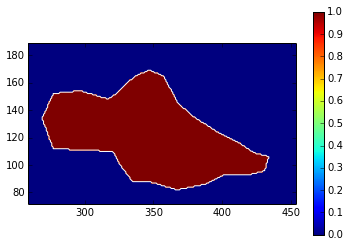

In [184]:
tiles = []
unique_tile_values = unique(mega_mask)
for tile_value in unique_tile_values:
    # Create masks for single valued tiles (so that they are more disconnected)
    singly_masked_img = np.zeros_like(mega_mask)
    for x,y in zip(*np.where(mega_mask==tile_value)):
        singly_masked_img[x][y]=1
    #Extract a set of contours from these masks
    x, y = np.mgrid[:singly_masked_img.shape[0], :singly_masked_img.shape[1]]
    c = cntr.Cntr(x, y, singly_masked_img)
    # trace a contour at z == 1
    res = c.trace(0.9)
    plot_trace_contours(res)
    for segment in res:
        if segment.dtype!=np.uint8:
            tiles.append(segment)

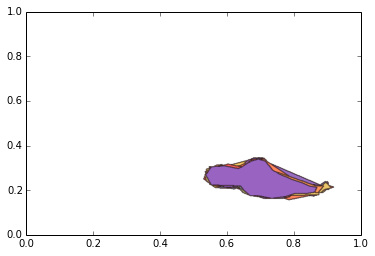

In [191]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots()
patches = []

for tile in tiles:
    polygon = Polygon(tile/500, True)
    patches.append(polygon)

p = PatchCollection(patches, cmap=matplotlib.cm.jet, alpha=0.4)

colors = 100*np.random.rand(len(patches))
p.set_array(np.array(colors))

ax.add_collection(p)

plt.show()

indicator is a binary vector that indicates whether the worker's annotation covered the specified region or not. 

In [201]:
from greedy import *
from data import *
from experiment import *
import pandas as pd 

In [206]:
# Generate M regions; Each region belongs to k annotators of a total of N
TestSet = SimulateSingleObject(N=10,M=50,IntersectionArea=10,MaxAreaOfOtherRegions=100)
TestSet.createNewMapping()
# TestSet.RegionToAreaMapping
gen_data_lst = gen_data(10,100,10,100,10,100)

In [207]:
shape(gen_data_lst)

(11, 100)

In [205]:
print gen_data_lst[0]

[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [209]:
shape(np.array(generateRawData(TestSet)))

(11, 50)

In [211]:
M = len(tiles)
worker_lst  = unique(bb_objects.worker_id)
N = len(worker_lst)

In [227]:
from shapely.geometry import Polygon

In [ ]:
for worker_indicator,i in zip(indicator_matrix,range(N+1)):
    tile = Polygon(tiles[i])
    # Check if worker's polygon contains this tile
    
    # Last row contains region area size
    if i==N+1:
        indicator_matrix
    

Since number of workers < number of tiles, lets loop through number of workers first 

In [ ]:
# for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"]):
#     xloc,yloc = process_raw_locs([x,y])
xylocs = [list(zip(*process_raw_locs([x,y]))) for x,y in zip(bb_objects["x_locs"],bb_objects["y_locs"])]

In [337]:
shape(indicator_matrix)

(42, 131)

In [357]:
PLOT=False
indicator_matrix = np.zeros((N+1,M))
for  wi in range(N):
    worker_id = worker_lst[wi]
    worker_bb_info = bb_objects[bb_objects["worker_id"]==worker_id]
    worker_BB_polygon = Polygon(zip(*process_raw_locs([worker_bb_info["x_locs"].values[0],worker_bb_info["y_locs"].values[0]])))
    # Check if worker's polygon contains this tile
    for tile_i in range(M):
        #tile = Polygon(tiles[tile_i])
        #Take the transpose of the tile graph polygon because during the tile creation process the xy was flipped
        tile= Polygon(zip(tiles[tile_i][:,1],tiles[tile_i][:,0]))
        if PLOT:
            plt.figure()
            plot_coords(tile)
            plot_coords(worker_BB_polygon,color="blue")
#         if worker_BB_polygon.intersects(tile):
        if worker_BB_polygon.contains(tile): 
#             print 'Here'
#             print worker_id,tile_i
            indicator_matrix[wi][tile_i]=1

In [368]:
shape(indicator_matrix)

(42, 131)

In [370]:
for tile_i in range(M):
    tile= Polygon(zip(tiles[tile_i][:,1],tiles[tile_i][:,0]))
    indicator_matrix[-1][tile_i]=tile.area

In [371]:
def plot_coords(ob,color='red'):
    '''
    Plot shapely coord 
    '''
    x, y = ob.exterior.xy
    plt.plot(x, y, '-', color=color, zorder=1)

<matplotlib.colorbar.Colorbar instance at 0x120be2908>

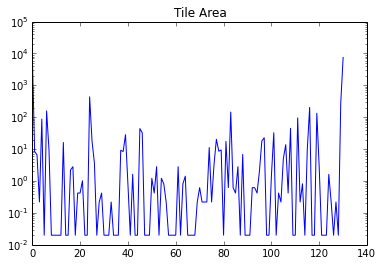

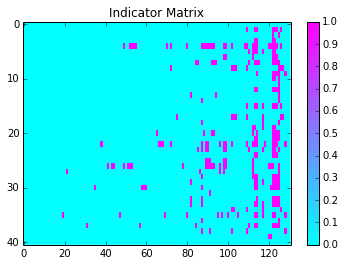

In [406]:
plt.title("Tile Area")
plt.semilogy(indicator_matrix[-1])
plt.figure()
plt.title("Indicator Matrix")
#Plot all excluding last row (area)
plt.imshow(indicator_matrix[:-1],cmap="cool",interpolation='none', aspect='auto')
plt.colorbar()

In [384]:
shape(indicator_matrix)

(42, 131)

##### Sanity check: some medium sized area tiles tends to be included by a lot of workers, these are probably good tiles 

<matplotlib.colorbar.Colorbar instance at 0x111709c68>

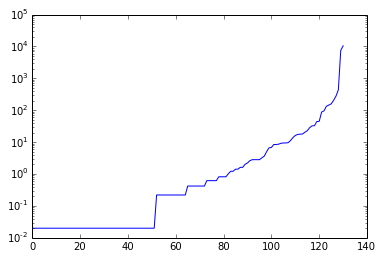

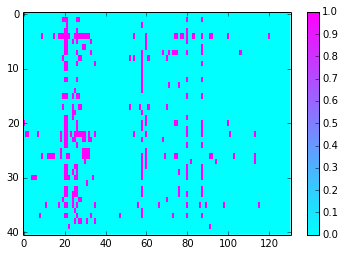

In [398]:
sorted_indicator_matrix = indicator_matrix[:,indicator_matrix[-1].argsort()]
plt.semilogy(sorted_indicator_matrix[-1])
plt.figure()
plt.imshow(sorted_indicator_matrix[:-1],cmap="cool",interpolation='none', aspect='auto')
plt.colorbar()

In [284]:
# Example testing whether shapely's contains function works.
big = Polygon([[0,0],[2,0],[2,2],[0,2]])
small = Polygon([[0,0],[1,0],[1,1],[0,1]])
big.contains(small)

True

In [ ]:
    # Last row contains region area size
    if i==N+1:
        indicator_matrix
